In [8]:
import sys
sys.path.append('./../NeuroDataResource/')

import pickle
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from NeuroDataResource import NeuroDataResource

token = pickle.load(open('./../NeuroDataResource/data/token.pkl', 'rb'))

In [4]:
myResource = NeuroDataResource(host = 'api.boss.neurodata.io',
                               token = token,
                               collection = 'collman',
                               experiment = 'collman15v2',
                               chanList = [{'name': 'annotation', 'dtype': 'uint64'},
                                           {'name': 'EM25K', 'dtype':'uint8'},
                                           {'name': 'GABA488', 'dtype':'uint8'},
                                           {'name': 'GAD647', 'dtype':'uint8'},
                                           {'name': 'gephyrin594', 'dtype':'uint8'},
                                           {'name': 'GS594', 'dtype':'uint8'},
                                           {'name': 'MBP488', 'dtype':'uint8'},
                                           {'name': 'NR1594', 'dtype':'uint8'},
                                           {'name': 'PSD95_488', 'dtype':'uint8'},
                                           {'name': 'Synapsin647', 'dtype':'uint8'},
                                           {'name': 'VGluT1_647', 'dtype':'uint8'}
                                          ])

In [5]:
cutouts = {}
for key in myResource._chanList.keys():
    if not 'EM' in key:
        print(key)
        cutout = myResource.get_cutout(chan=key, zRange=[5, 15], yRange=[1000, 2000], xRange=[1000, 2500])
        cutouts[key] = cutout

NR1594
gephyrin594
GAD647
annotation
Synapsin647
GABA488
VGluT1_647
GS594
MBP488
PSD95_488


In [6]:
ledger = []
chans = []
for key, value in cutouts.items():
    if not 'annotation' in key and not 'DAPI' in key:
        ledger.append(key)
        chans.append(value)
    
volume = np.stack(chans)

In [116]:
def do_pca(volume, chans, annotation):
    numComp=5
    
    volume = np.moveaxis(volume, 0, -1).reshape([-1, chans]) 
    model = PCA(n_components=numComp, whiten=True)
    model = model.fit(volume)
    img = (model.transform(volume)).reshape(10, 1000, 1500, numComp)
    
    positive = img[annotation > 0]
    negative = img[annotation == 0]
    
   
    for dim in range(img.shape[3]):
        plt.figure()
        plt.title('KDE of PC: '+str(dim))
        xs = np.linspace(np.min(img[:, :, :, dim]),
                         np.max(img[:, :, :, dim]),
                        100)

        pos_kde = gaussian_kde(positive[:, dim])
        neg_kde = gaussian_kde(negative[:, dim])
        plt.plot(xs, pos_kde(xs), c='g')
        plt.plot(xs, neg_kde(xs), c='r')
        plt.show()
        
    kernelImg = np.sum(np.power(img, 2), 3)
    positive = kernelImg[annotation > 0]
    negative = kernelImg[annotation == 0]
    
    plt.figure()
    plt.title("Quadratic Kernel KDE")
    xs = np.linspace(np.min(kernelImg),
                     np.max(kernelImg),
                    100)

    pos_kde = gaussian_kde(positive)
    neg_kde = gaussian_kde(negative)
    plt.plot(xs, pos_kde(xs), c='g')
    plt.plot(xs, neg_kde(xs), c='r')
    plt.show()
    
    return model, img, kernelImg

[[  2.58734685e-02  -1.24217935e-01   1.62259496e-01   9.06519062e-01
    1.72623781e-02   2.71074474e-01  -7.86801900e-03  -9.63978219e-02
    2.29481390e-01]
 [ -7.93939877e-04   9.54284383e-01   1.84094021e-01   1.23890269e-01
    2.73202451e-02  -3.31550064e-02   1.87713862e-01   2.54982482e-02
   -4.86720996e-02]
 [  6.44761935e-02   6.20249295e-02   1.39116118e-01  -3.08866841e-01
    8.55742798e-03   2.56269801e-01   1.24278897e-02   1.14903967e-01
    8.93386195e-01]
 [  2.64544975e-02  -4.36375153e-02   5.07038570e-03   1.18482404e-01
    9.96245171e-03   9.33159239e-04  -1.89214799e-02   9.87676996e-01
   -8.58379081e-02]
 [  3.40578223e-02  -1.25474093e-01   8.70539991e-01  -1.97268588e-01
    2.31771750e-02   3.07435852e-01  -1.05930708e-01  -1.43740806e-02
   -2.82594465e-01]]


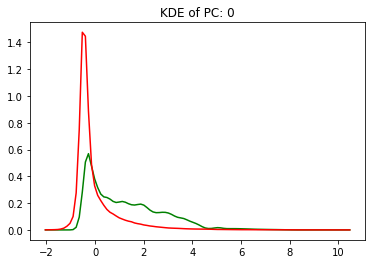

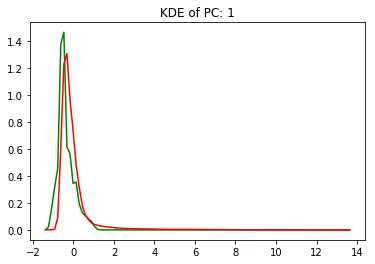

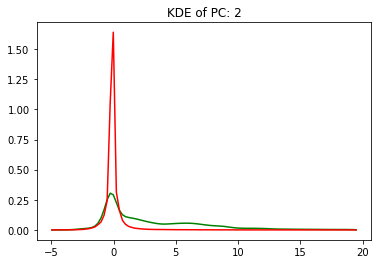

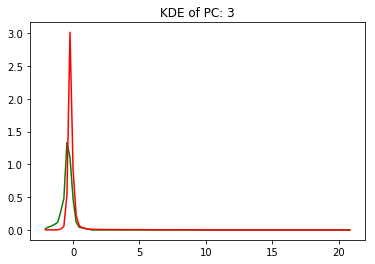

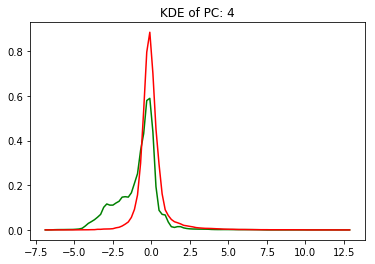

In [29]:
model, img = do_pca(volume, 9, cutouts['annotation'])

In [96]:
cutouts = {}
for key in myResource._chanList.keys():
    if not 'EM' in key:
        print(key)
        cutout = myResource.get_cutout(chan=key, zRange=[5, 15], yRange=[1000, 2000], xRange=[1000, 2500])
        cutouts[key] = cutout

NR1594
gephyrin594
GAD647
annotation
Synapsin647
GABA488
VGluT1_647
GS594
MBP488
PSD95_488


In [97]:
ledger = []
chans = []
for key, value in cutouts.items():
    if not 'annotation' in key and not 'DAPI' in key:
        ledger.append(key)
        chans.append(value)
    
volume = np.stack(chans)

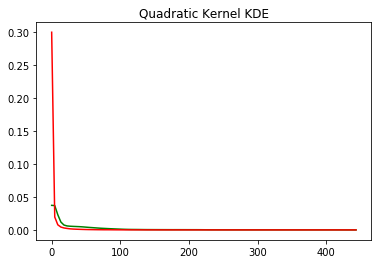

In [98]:
model, img, kernelImg = do_pca(volume, 9, cutouts['annotation'])

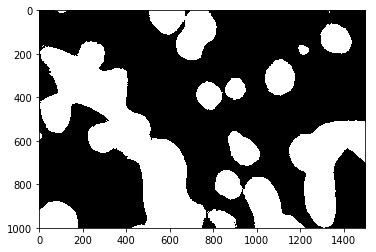

In [115]:
plt.figure()
plt.imshow(np.array(kernelImg[1]).astype(int) > 0, cmap='gray')
plt.show()

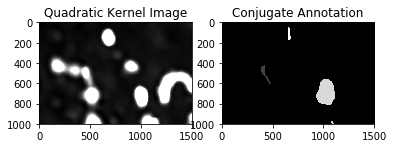

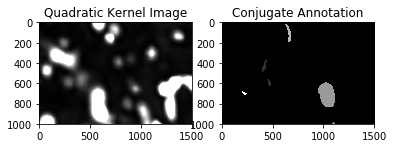

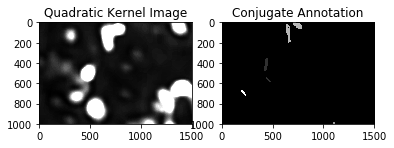

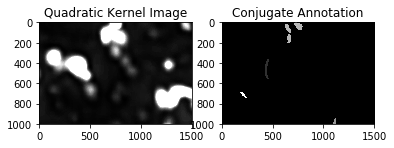

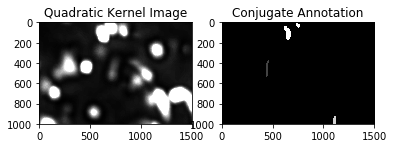

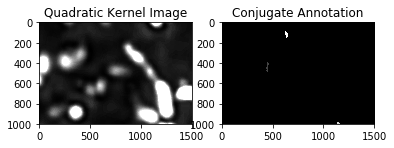

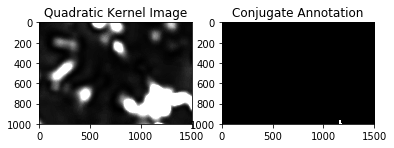

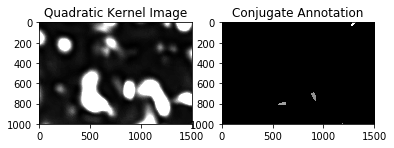

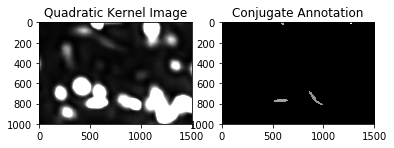

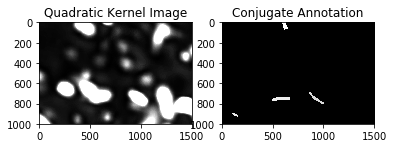

In [100]:
for i in range(10):
    plt.subplot(121)
    plt.title('Quadratic Kernel Image')
    plt.imshow(np.clip(kernelImg[i], 0, 10) , cmap='gray')
    plt.subplot(122)
    plt.title('Conjugate Annotation')
    plt.imshow(cutouts['annotation'][i, :, :], cmap='gray')
    plt.show()

In [101]:
preSyn = np.stack([cutouts['Synapsin647'],
                   cutouts['VGluT1_647'],
                   cutouts['GAD647']])

postSyn = np.stack([cutouts['PSD95_488'],
                    cutouts['GABA488'],
                    cutouts['gephyrin594']])

preSyn.shape
postSyn.shape

(3, 10, 1000, 1500)

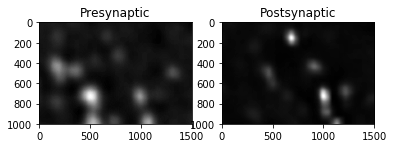

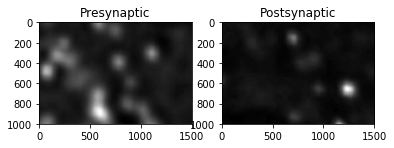

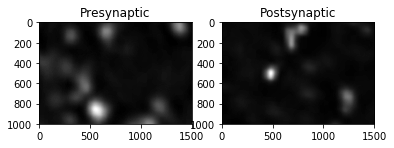

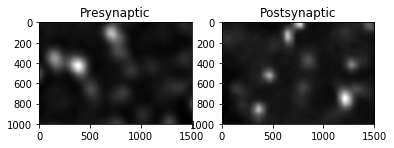

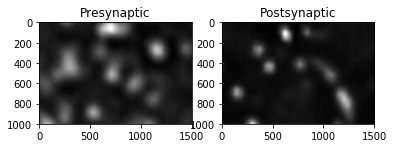

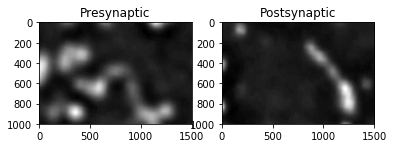

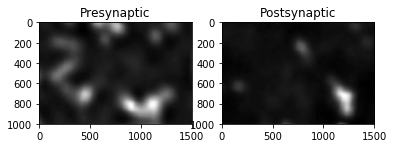

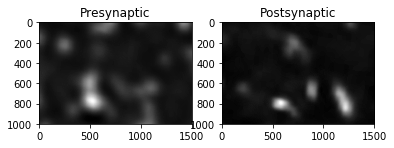

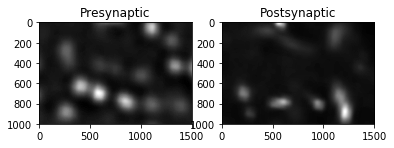

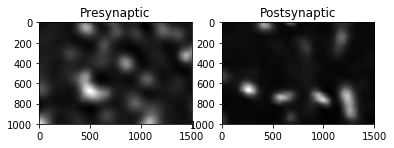

In [102]:
plt.figure()
for i in range(10):
    plt.subplot(121)
    plt.title('Presynaptic')
    plt.imshow(np.sum(preSyn, axis=0)[i] , cmap='gray')
    plt.subplot(122)
    plt.title('Postsynaptic')
    plt.imshow(np.sum(postSyn, axis=0)[i], cmap='gray')
    plt.show()

In [107]:
from skimage.morphology import dilation as dilate 

In [111]:
dilPreSyn = np.sum(preSyn, axis=0)
for i in range(3):
    dilPreSyn = np.stack(dilate(dilPreSyn))
    
dilPostSyn = np.sum(preSyn, axis=0)
for i in range(3):
    dilPostSyn = np.stack(dilate(dilPostSyn))

In [113]:
dilationOverlap = (dilPreSyn + dilPostSyn) - (dilate(np.sum(preSyn, axis=0)) + dilate(np.sum(postSyn, axis=0)))
print(dilationOverlap.shape)

(10, 1000, 1500)


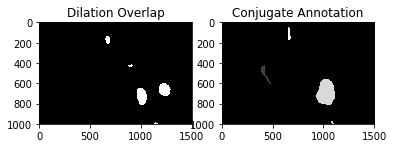

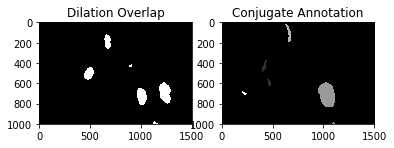

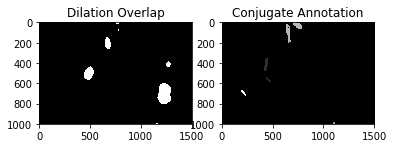

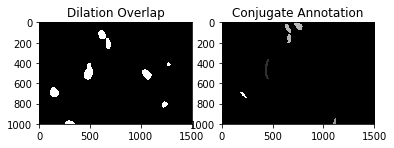

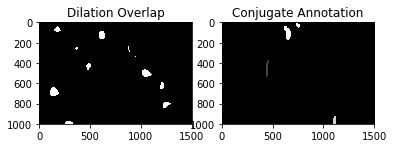

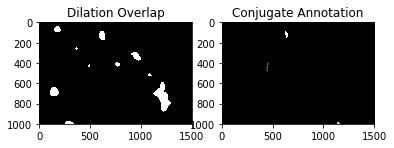

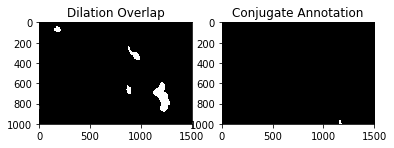

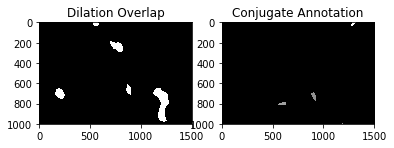

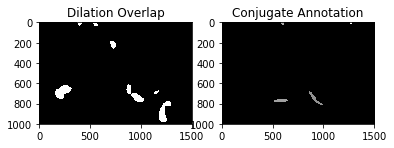

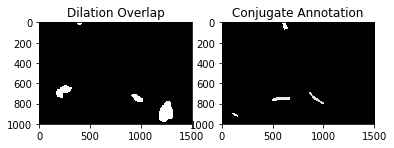

In [114]:
for i in range(10):
    plt.subplot(121)
    plt.title('Dilation Overlap')
    plt.imshow(dilationOverlap[i], cmap='gray')
    plt.subplot(122)
    plt.title('Conjugate Annotation')
    plt.imshow(cutouts['annotation'][i, :, :], cmap='gray')
    plt.show()

In [117]:
sys.path.append('../Quality/')
from Quality import compute_overlap_array

In [ ]:
plt.figure()
plt.hist(compute_overlap_array(dilationOverlap, cutouts['annotation']))
plt.show()